In [3]:
import os.path as osp
from typing import List

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import exp_utils
import posggym

import exp_utils
from plot_utils import heatmap, annotate_heatmap

# Data loading

Here we load the data from the results file, removed unused columns and add 95% CI, K level and train env columns.

In [16]:
def get_k(row):
    pi_name = row["policy_name"]
    if "Random" in pi_name:
        return str(-1)
    elif "BAPOSGMCP" in pi_name:
        return "BA"
    try:
        return pi_name.split("_")[-1]
    except Exception:
        raise Exception("Policy name error")
        

def get_train_env(row):
    if "policy_dir" not in row:
        return 'None'
    
    policy_dir = row["policy_dir"]
    if policy_dir in (None, 'None', np.nan):
        # random or some other fixed policy
        return 'None'
    
    # get only final directory in path
    policy_dir = osp.basename(osp.normpath(policy_dir))
    
    # expect '<env_name>_<timestamp>'
    tokens = policy_dir.split("_")
    assert len(tokens) == 2
    return tokens[0]


def import_data(results_dir):
    results_file = osp.join(exp_utils.EXP_RESULTS_DIR, results_dir, "compiled_results.csv")
    df = pandas.read_csv(results_file)

    columns_to_drop = [
        'Unnamed: 0', 
        'episode_step_limit', 
        'time_limit', 
        'search_time_mean', 
        'search_time_std', 
        'update_time_mean', 
        'update_time_std',
        'reinvigoration_time_mean', 
        'reinvigoration_time_std', 
        'policy_calls_mean', 
        'policy_calls_std', 
        'inference_time_mean', 
        'inference_time_std',
        'episode_dones', 
    ]
    df = df.drop(columns_to_drop, axis=1)

    # Add 95% CI
    def conf_int(row, prefix):
        std = row[f"{prefix}_std"]
        n = row["num_episodes"]
        return 1.96 * (std / np.sqrt(n))

    prefix = ""
    for col in df.columns:
        if not col.endswith("_std"):
            continue
        prefix = col.replace("_std", "")
        df[f"{prefix}_CI"] = df.apply(
            lambda row: conf_int(row, prefix), axis=1
        )
        
    df["K"] = df.apply(get_k, axis=1)
    df["train_env_name"] = df.apply(get_train_env, axis=1)
        
    return df

In [17]:
rl_policies_results_dir_name = '2022-05-17 14:39:29.828688'
baposgmcp_results_dir_name = '2022-05-17 22:19:51.322769'

rl_df = import_data(rl_policies_results_dir_name)
ba_df = import_data(baposgmcp_results_dir_name)

print(f"{rl_df.columns=}")
print(f"{ba_df.columns=}")

rl_df.columns=Index(['exp_id', 'agent_id', 'env_name', 'seed', 'num_episodes', 'policy_name',
       'policy_dir', 'policy_id', 'episode_returns_mean',
       'episode_returns_std', 'episode_returns_max', 'episode_returns_min',
       'episode_discounted_returns_mean', 'episode_discounted_returns_std',
       'episode_discounted_returns_max', 'episode_discounted_returns_min',
       'episode_steps_mean', 'episode_steps_std', 'episode_times_mean',
       'episode_times_std', 'num_outcome_LOSS', 'num_outcome_DRAW',
       'num_outcome_WIN', 'num_outcome_NA', 'episode_returns_CI',
       'episode_discounted_returns_CI', 'episode_steps_CI', 'episode_times_CI',
       'K', 'train_env_name'],
      dtype='object')
ba_df.columns=Index(['exp_id', 'agent_id', 'env_name', 'seed', 'num_episodes', 'policy_name',
       'other_policy_prior', 'num_sims', 'c_init', 'c_base', 'truncated',
       'reinvigorator', 'extra_particles_prop', 'step_limit', 'epsilon',
       'args', 'other_agent_policy_dir', 

# Plotting

In [18]:
print(ba_df["policy_id"].unique())
print("Test Envs:", ba_df["env_name"].unique())
print("Train Envs:", ba_df["train_env_name"].unique())
print("Policy K:", ba_df["K"].unique())

['None' 'pi_-1' 'pi_SP' 'pi_1' 'pi_BR' 'pi_0']
Test Envs: ['Driving7x7CrissCross1-v0' 'Driving7x7CrissCross2-v0']
Train Envs: ['None' 'Driving7x7CrissCross1-v0' 'Driving7x7CrissCross2-v0']
Policy K: ['BA' '-1' 'SP' '1' 'BR' '0']


In [19]:
def get_pw_returns(plot_df,
                   test_env: str, 
                   agent_0_train_env: str,
                   agent_1_train_env: str):
    test_df = plot_df[plot_df["env_name"] == test_env]
    agent_ids = test_df["agent_id"].unique()
    agent_ids.sort()
    k_levels = test_df["K"].unique()
    k_levels.sort()

    pw_returns = np.zeros((len(k_levels), len(k_levels)))
    row_agent = agent_ids[1]
    col_agent = agent_ids[0]

    for c, col_k in enumerate(k_levels):
        col_agent_df = test_df[
            (test_df["K"] == col_k)
            & (test_df["train_env_name"].isin([agent_1_train_env, 'None']))
        ]
        col_agent_exp_ids = col_agent_df["exp_id"]
        for r, row_k in enumerate(reversed(k_levels)):
            # print(col_k, row_k)
            row_agent_df = test_df[
                (test_df["K"] == row_k)
                & (test_df["train_env_name"].isin([agent_0_train_env, 'None']))
                & (test_df["exp_id"].isin(col_agent_exp_ids))
            ]
            # since env is symmetric it's possible that (col_k, row_k) pairing happened multiple times
            # with agents swapping agent ids, so in that case we just take average performance across 
            # agent ids
            x = row_agent_df["episode_discounted_returns_mean"]
            # print("x", x)
            if len(x) == 0:
                # do this so we can see where error is
                x = np.nan
            elif len(x) > 1:
                x = x.mean()
            
            pw_returns[r][c] = x
    
    return k_levels, pw_returns


def plot_pw_heatmap(ax,
                    plot_df,
                    test_env: str,
                    agent_0_env: str,
                    agent_1_env: str):
    k_levels, pw_returns = get_pw_returns(plot_df, test_env, agent_0_env, agent_1_env)

    im, cbar = heatmap(
        data=pw_returns, 
        row_labels=reversed(k_levels),
        col_labels=k_levels,
        ax=ax,
        show_cbar=False,
        cmap="viridis",
        cbarlabel="mean return (row agent)",
        vmin=-0.2,
        vmax=1.0
    )
    texts = annotate_heatmap(
        im, 
        valfmt="{x:.2f}",
        textcolors=("white", "black")
    )
    ax.set_title(f"In\n{test_env}\n vs agents from\n{agent_1_env}")

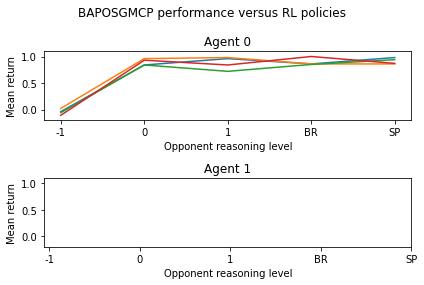

In [23]:
agent_ids = ba_df["agent_id"].unique()
agent_ids.sort()
k_levels = ba_df["K"].unique()
k_levels.sort()

fig, axs = plt.subplots(2)
for i, agent_id in enumerate(agent_ids):
    opp_id = (agent_id + 1) % 2
    ax = axs[i]
    agent_df = ba_df[ba_df["agent_id"] == agent_id]
    exp_ids = agent_df[agent_df["K"] == "BA"]["exp_id"]
    x = []
    y = []
    for k in k_levels:
        if k == "BA":
            continue
        opp_df = ba_df[
            (ba_df["agent_id"] == opp_id) 
            & (ba_df["exp_id"].isin(exp_ids))
            & (ba_df["K"] == k)
        ]
        x.append(k)
        y.append(opp_df["episode_returns_mean"])
    
    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_xlabel("Opponent reasoning level")
    ax.set_ylabel("Mean return")
    ax.set_title(f"Agent {agent_id}")
    ax.set_ylim(-0.2, 1.1)
    
fig.suptitle("BAPOSGMCP performance versus RL policies")
fig.tight_layout()
fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_baposgmcp_performance.png"))
plt.show()

In [40]:
def plot_pw_heatmap(ax, 
                    plot_rl_df, 
                    plot_ba_df,
                    test_env: str,
                    rl_agent_0_env: str,
                    rl_agent_1_env: str):
    rl_k_levels, rl_pw_returns = get_pw_returns(plot_rl_df, test_env, rl_agent_0_env, rl_agent_1_env)
    rl_k_levels = rl_k_levels.tolist()
    row_rl_k_levels = list(reversed(rl_k_levels))
    
    ba_test_df = plot_ba_df[plot_ba_df["env_name"] == test_env]
    agent_ids = ba_test_df["agent_id"].unique()
    agent_ids.sort()
    ba_k_levels = ba_test_df["K"].unique()
    ba_k_levels.sort()

    all_pw_returns = np.zeros((len(ba_k_levels), len(ba_k_levels)))
    row_agent = agent_ids[0]
    col_agent = agent_ids[1]

    for c, col_k in enumerate(ba_k_levels):
        for r, row_k in enumerate(reversed(ba_k_levels)):
            if col_k == "BA":
                all_pw_returns[r][c] = np.nan
            elif row_k != "BA":
                # copy result from RL pairwise result
                row_k_idx = row_rl_k_levels.index(row_k)
                col_k_idx = rl_k_levels.index(col_k)
                all_pw_returns[r][c] = rl_pw_returns[row_k_idx][col_k_idx]
            else:
                # get result from BAPOSGMCP dataframe
                col_agent_exp_ids = ba_test_df[
                    (ba_test_df["agent_id"] == col_agent) 
                    & (ba_test_df["K"] == col_k)
                ]["exp_id"]

                y = ba_test_df[
                    (ba_test_df["agent_id"] == row_agent) 
                    & (ba_test_df["K"] == row_k)
                    & (ba_test_df["exp_id"].isin(col_agent_exp_ids))
                ]["episode_returns_mean"]

                if len(y) == 0:
                    # do this so we can see where error is
                    y = np.nan
                elif len(y) > 1:
                    y = y.mean()

                all_pw_returns[r][c] = y

    im, cbar = heatmap(
        data=all_pw_returns, 
        row_labels=reversed(ba_k_levels),
        col_labels=ba_k_levels,
        ax=ax,
        show_cbar=False,
        cmap="viridis",
        cbarlabel="mean return (row agent)",
        vmin=-0.2,
        vmax=1.0
    )
    texts = annotate_heatmap(
        im, 
        valfmt="{x:.2f}",
        textcolors=("white", "black")
    )
    ax.set_title(f"In\n{test_env}\n vs agents from\n{rl_agent_1_env}")

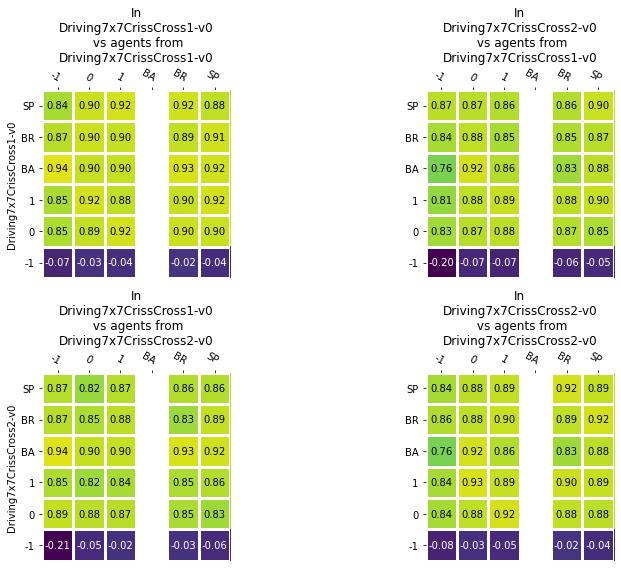

In [41]:
rl_train_envs = rl_df["train_env_name"].unique()
rl_train_envs.sort()

test_envs = ba_df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(rl_train_envs), ncols=len(test_envs), figsize=(12, 8))
for fig_r, rl_env in enumerate(rl_train_envs):
    for fig_c, col_env in enumerate(test_envs):
        ax = axs[fig_r][fig_c]
        plot_pw_heatmap(
            ax, 
            rl_df, 
            ba_df, 
            test_env=col_env, 
            rl_agent_0_env=col_env, 
            rl_agent_1_env=rl_env
        )

        if fig_c == 0:
            ax.set_ylabel(rl_env)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "all_pw_performance.png"))
plt.show()

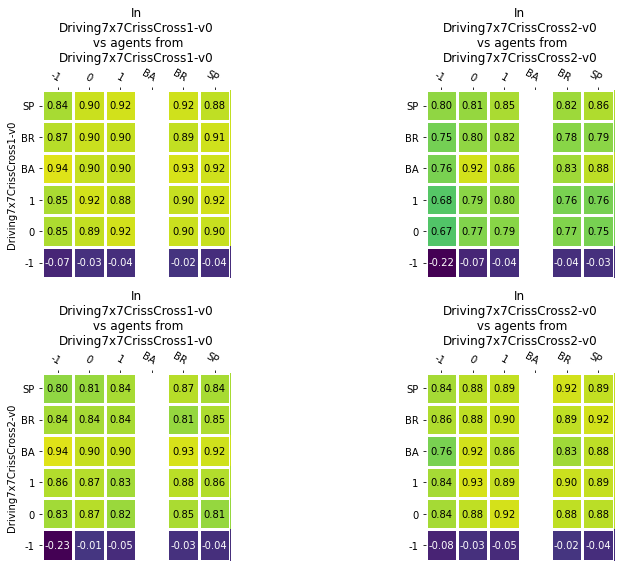

In [42]:
rl_train_envs = rl_df["train_env_name"].unique()
rl_train_envs.sort()

test_envs = ba_df["env_name"].unique()
test_envs.sort()

fig, axs = plt.subplots(nrows=len(rl_train_envs), ncols=len(test_envs), figsize=(12, 8))
for fig_r, rl_env in enumerate(rl_train_envs):
    for fig_c, col_env in enumerate(test_envs):
        ax = axs[fig_r][fig_c]
        plot_pw_heatmap(
            ax, 
            rl_df, 
            ba_df, 
            test_env=col_env, 
            rl_agent_0_env=rl_env, 
            rl_agent_1_env=col_env
        )

        if fig_c == 0:
            ax.set_ylabel(rl_env)

fig.tight_layout()
# fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "all_pw_performance.png"))
plt.show()